## Using Foursquare API to get the nearby venues for each house

In [243]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from fuzzywuzzy import fuzz
import requests
import os
from bs4 import BeautifulSoup
import time
import sys
import regex as re
import requests
import lxml
from lxml.html.soupparser import fromstring
import numbers
import sqlite3

In [11]:
# load scaped dataset and display the first 5 rows.

data = pd.read_csv('D:/Downloads/Data Preparation/tmp0tolbwlf.csv')
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779,"(42.32512200, -71.10777900)"
2,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709,"(42.29755500, -71.05970900)"
3,I92094519,3126,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,765,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,BROOKS ST,42.355120,-71.162678,"(42.35512000, -71.16267800)"
4,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,42.309718,-71.104294,"(42.30971800, -71.10429400)"


In [12]:
# Rename the columns for convinence

data = data.drop(['INCIDENT_NUMBER','REPORTING_AREA','OFFENSE_CODE','STREET'], axis=1)
crimedata = data.rename(columns={'OFFENSE_CODE_GROUP':'Group', 'OFFENSE_DESCRIPTION':'Description','OCCURRED_ON_DATE':'Date'})

In [13]:
crimedata.head()

,Group,Description,DISTRICT,SHOOTING,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,Lat,Long,Location
0,NaN,ASSAULT - AGGRAVATED,External,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,NaN,NaN,"(0.00000000, 0.00000000)"
1,NaN,VERBAL DISPUTE,E13,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,42.325122,-71.107779,"(42.32512200, -71.10777900)"
2,NaN,INVESTIGATE PERSON,C11,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,42.297555,-71.059709,"(42.29755500, -71.05970900)"
3,NaN,WARRANT ARREST - OUTSIDE OF BOSTON WARRANT,D14,0,2019-11-22 07:50:00,2019,11,Friday,7,NaN,42.355120,-71.162678,"(42.35512000, -71.16267800)"
4,NaN,SICK ASSIST,E13,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,42.309718,-71.104294,"(42.30971800, -71.10429400)"


In [14]:
crimedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492223 entries, 0 to 492222
Data columns (total 13 columns):
Group          426839 non-null object
Description    492223 non-null object
DISTRICT       489789 non-null object
SHOOTING       67130 non-null object
Date           492223 non-null object
YEAR           492223 non-null int64
MONTH          492223 non-null int64
DAY_OF_WEEK    492223 non-null object
HOUR           492223 non-null int64
UCR_PART       426729 non-null object
Lat            463701 non-null float64
Long           463701 non-null float64
Location       492223 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 48.8+ MB


In [15]:
# Check the outlier and bad value for Shooting.

crimedata['SHOOTING'].unique()

array(['0', nan, 'Y', 0.0, 1.0], dtype=object)

In [16]:
def replace(instr):
    if instr in ['0', 0.0]:
        return 'N'
    elif instr==1.0:
        return 'Y'
    elif instr=='Y':
        return 'Y'
    else:
        return instr

In [17]:
crimedata.SHOOTING  = crimedata.SHOOTING.apply(replace)

In [18]:
crimedata['SHOOTING'].unique()

array(['N', nan, 'Y'], dtype=object)

In [19]:
# Drop the missing values.

crimedf= crimedata.dropna()

In [20]:
crimedf.head()

,Group,Description,DISTRICT,SHOOTING,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,Lat,Long,Location
902,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,B2,Y,2019-09-26 02:38:00,2019,9,Thursday,2,Part One,42.324098,-71.084830,"(42.32409762, -71.08483043)"
903,Ballistics,BALLISTICS EVIDENCE/FOUND,B2,Y,2019-09-26 02:38:00,2019,9,Thursday,2,Part Two,42.324098,-71.084830,"(42.32409762, -71.08483043)"
915,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,C11,Y,2019-09-25 23:42:00,2019,9,Wednesday,23,Part One,42.300980,-71.068699,"(42.30098009, -71.06869928)"
2806,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,B3,Y,2019-09-19 17:16:00,2019,9,Thursday,17,Part One,42.300068,-71.083369,"(42.30006755, -71.08336910)"
3432,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,B2,Y,2019-09-17 22:35:00,2019,9,Tuesday,22,Part One,42.311955,-71.078719,"(42.31195475, -71.07871912)"


In [21]:
# Check the outlier and bad value for Group.

crimedf['Group'].unique()

array(['Aggravated Assault', 'Ballistics', 'Vandalism', 'Homicide',
       'Warrant Arrests', 'Auto Theft', 'Drug Violation',
       'Firearm Violations', 'Police Service Incidents', 'Other',
       'Motor Vehicle Accident Response', 'Towed', 'Firearm Discovery',
       'Medical Assistance', 'Search Warrants',
       'Recovered Stolen Property', 'Investigate Person',
       'Investigate Property', 'Robbery', 'Simple Assault',
       'Disorderly Conduct', 'Property Lost', 'Violations',
       'Manslaughter', 'Property Related Damage', 'Property Found',
       'Missing Person Located'], dtype=object)

In [22]:
# Check the outlier and bad value for Description.

crimedf['Description'].unique()

array(['ASSAULT - AGGRAVATED - BATTERY', 'BALLISTICS EVIDENCE/FOUND',
       'VANDALISM', 'MURDER, NON-NEGLIGIENT MANSLAUGHTER',
       'WARRANT ARREST', 'AUTO THEFT - LEASED/RENTED VEHICLE',
       'DRUGS - CLASS B TRAFFICKING OVER 18 GRAMS',
       'WEAPON - FIREARM - CARRYING / POSSESSING, ETC',
       'SERVICE TO OTHER PD INSIDE OF MA.', 'ASSAULT - AGGRAVATED',
       'WEAPON - OTHER - CARRYING / POSSESSING, ETC',
       'WEAPON - FIREARM - OTHER VIOLATION',
       'WEAPON - OTHER - OTHER VIOLATION',
       'M/V - LEAVING SCENE - PROPERTY DAMAGE', 'TOWED MOTOR VEHICLE',
       'FIREARM/WEAPON - FOUND OR CONFISCATED',
       'M/V ACCIDENT - PROPERTY \xa0DAMAGE',
       'DRUGS - POSS CLASS B - COCAINE, ETC.', 'INTIMIDATING WITNESS',
       'DEATH INVESTIGATION', 'SEARCH WARRANT',
       'DRUGS - POSS CLASS D - INTENT TO MFR DIST DISP',
       'STOLEN PROPERTY - BUYING / RECEIVING / POSSESSING',
       'VAL - VIOLATION OF AUTO LAW - OTHER', 'INVESTIGATE PERSON',
       'M/V ACCIDENT -

Text(0, 0.5, 'Counts')

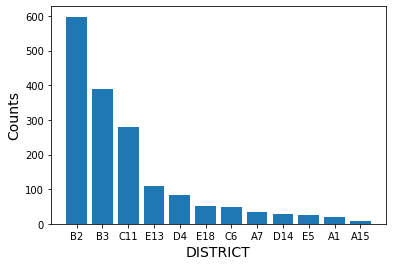

In [23]:
# Check the outlier and bad value for District.Boston police districts have A1, A7, A15 ,B2, B3, C6, C11, D4, D14, E5, E15, E13,
# E18.You can see no outlier and bad value.

num_D = len(crimedf.DISTRICT.unique())
plt.bar(range(num_D), crimedf.DISTRICT.value_counts())
plt.xticks(range(num_D), crimedf.DISTRICT.value_counts().index)
plt.xlabel('DISTRICT', fontsize=14)
plt.ylabel('Counts', fontsize=14)

In [24]:
# Check the outlier and bad value for Date. This data set is a crime incident reports form 2015 to date. You can see no outlier
# and bad value.

crimedf['Date'] = pd.to_datetime(crimedf['Date'] )

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
crimedf['Date'].max()

Timestamp('2019-09-26 02:38:00')

In [26]:
crimedf['Date'].min()

Timestamp('2015-06-16 20:41:00')

Text(0, 0.5, 'Counts')

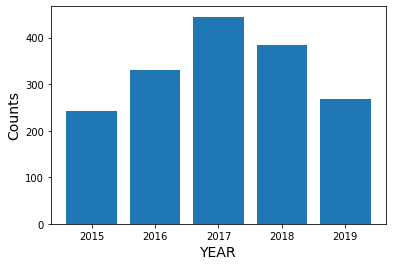

In [27]:
# Check the outlier and bad value for Year. This data set is a crime incident reports form 2015 to date. You can see no outlier 
# and bad value.

num_Y = len(crimedf.YEAR.unique())
plt.bar(range(num_Y), crimedf.YEAR.value_counts().sort_index())
plt.xticks(range(num_Y), crimedf.YEAR.value_counts().sort_index().index)
plt.xlabel('YEAR', fontsize=14)
plt.ylabel('Counts', fontsize=14)

Text(0.5, 0, 'Month')

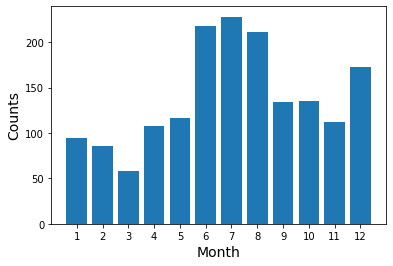

In [28]:
# Check the outlier and bad value for Month.You can see no outlier and bad value.

num_M = len(crimedf.MONTH.unique())
plt.bar(range(num_M), crimedf.MONTH.value_counts().sort_index())
plt.xticks(range(num_M), crimedf.MONTH.value_counts().sort_index().index)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Month', fontsize=14)

Text(0, 0.5, 'Counts')

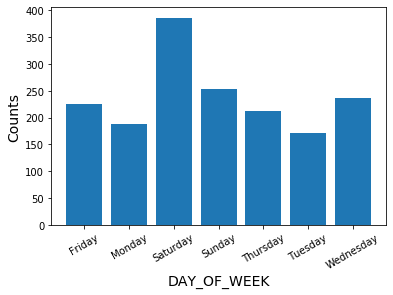

In [29]:
# Check the outlier and bad value for Day of week.You can see no outlier and bad value.

num_day = len(crimedf.DAY_OF_WEEK.unique())
plt.bar(range(num_day), crimedf.DAY_OF_WEEK.value_counts().sort_index())
plt.xticks(range(num_day), crimedf.DAY_OF_WEEK.value_counts().sort_index().index)
plt.xlabel('DAY_OF_WEEK', fontsize=14)
plt.xticks(rotation=30)
plt.ylabel('Counts', fontsize=14)

Text(0, 0.5, 'Counts')

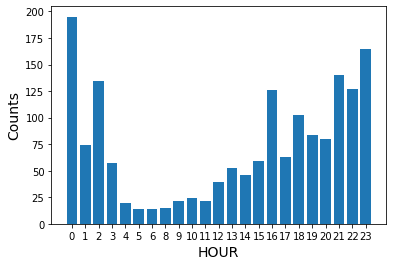

In [30]:
# Check the outlier and bad value for Hour.You can see no outlier and bad value

num_h = len(crimedf.HOUR.unique())
plt.bar(range(num_h), crimedf.HOUR.value_counts().sort_index())
plt.xticks(range(num_h), crimedf.HOUR.value_counts().sort_index().index)
plt.xlabel('HOUR', fontsize=14)
plt.ylabel('Counts', fontsize=14)

Text(0, 0.5, 'Counts')

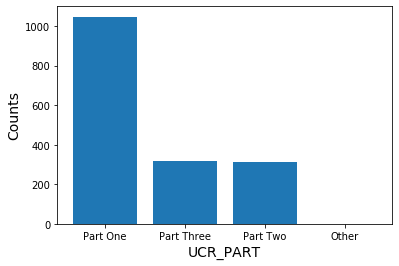

In [31]:
# Check the outlier and bad value for UCR_PART. UCR_PART means universal crime reporting part number, including 1, 2, 3. You can
# see no outlier and bad value.

num_UCR = len(crimedf.UCR_PART.unique())
plt.bar(range(num_UCR), crimedf.UCR_PART.value_counts())
plt.xticks(range(num_UCR), crimedf.UCR_PART.value_counts().index)
plt.xlabel('UCR_PART', fontsize=14)
plt.ylabel('Counts', fontsize=14)

In [32]:
# Check the outlier and bad value for latitude and longitude. You can see no outlier and bad value, all these incidents were 
# happended in Boston. 

latitude = 42.3601
longitude = -71.0589
crime_map = folium.Map(location=[latitude, longitude], zoom_start=12)

incidents = folium.map.FeatureGroup()
for lat, lng in zip(crimedf.Lat, crimedf.Long):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7,
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4))

crime_map.add_child(incidents)

In [33]:
# Column Location includes latitude and longitude, I will use fuzzy match to check any wrong with Location.The outcomes show 
# there is no outlier and bad value.

fuzzy_df = pd.DataFrame()
crimedf['fuzzy_Long'] = [fuzz.partial_ratio(str(crimedf.Long.iloc[i])[:8], crimedf.Location.iloc[i]) for i in range(crimedf.shape[0])]
crimedf['fuzzy_Lat'] = [fuzz.partial_ratio(str(crimedf.Lat.iloc[i])[:8], crimedf.Location.iloc[i]) for i in range(crimedf.shape[0])]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
crimedf.fuzzy_Lat.value_counts()

100    1673
Name: fuzzy_Lat, dtype: int64

In [35]:
crimedf.fuzzy_Long.value_counts()

100    1673
Name: fuzzy_Long, dtype: int64

In [36]:
# set some display settings for notebooks

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [37]:
# add headers in case you use chromedriver (captchas are no fun); namely used for chromedriver

req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

In [38]:
# create url variables for each zillow page

with requests.Session() as s:
    city = 'boston/' #*****change this city to what you want!!!!*****
    
    urls = []
    urls.append('https://www.zillow.com/homes/for_sale/'+city)
    for i in range(2, 26):
        urls.append('https://www.zillow.com/homes/for_sale/'+city+str(i)+'_p/')

    rs = [s.get(url, headers=req_headers) for url in urls]

In [39]:
# add contents of urls to soup variable from each url

soups = [BeautifulSoup(r.content, 'html.parser') for r in rs]

In [40]:
df = pd.DataFrame()

In [41]:
# all for loops are pulling the specified variable using beautiful soup and inserting into said variable

for soup in soups:
    temp_df = pd.DataFrame()
    for i in soup:
        address = soup.find_all (class_= 'list-card-addr')
        price = list(soup.find_all (class_='list-card-price'))
        beds = list(soup.find_all("ul", class_="list-card-details"))
        details = soup.find_all ('div', {'class': 'list-card-details'})
        home_type = soup.find_all ('div', {'class': 'list-card-footer'})
        last_updated = soup.find_all ('div', {'class': 'list-card-top'})
        brokerage = list(soup.find_all(class_= 'list-card-brokerage list-card-img-overlay',text=True))
        link = soup.find_all (class_= 'list-card-link')

        #create dataframe columns out of variables
        temp_df['prices'] = price
        temp_df['address'] = address
        temp_df['beds'] = beds

    # create empty url list
    url_refs = []

    # loop through url, pull the href and strip out the address tag
    for link in soup.find_all("article"):
        href = link.find('a',class_="list-card-link")
        addresses = href.find('address')
        addresses.extract()
        url_refs.append(href)

    # import urls into a links column
    temp_df['links'] = url_refs
    temp_df['links'] = temp_df['links'].astype('str')

    # remove html tags
    temp_df['links'] = temp_df['links'].replace('<a class="list-card-link" href="', ' ', regex=True)
    temp_df['links'] = temp_df['links'].replace('" tabindex="0"></a>', ' ', regex=True)
    temp_df['links'] = temp_df['links'].replace('<aaria-hidden="false"class="list-card-linkcarousel-list-card-link-no-activation"href="', '', regex=True)
    
    if df.shape[0] < temp_df.shape[0]:
        df = temp_df
    else:
        df = pd.concat([df, temp_df], axis=0)

In [42]:
# convert columns to str

df['prices'] = df['prices'].astype('str')
df['address'] = df['address'].astype('str')
df['beds'] = df['beds'].astype('str')

In [43]:
# remove html tags

df['prices'] = df['prices'].replace('<div class="list-card-price">', ' ', regex=True)
df['address'] = df['address'].replace('<address class="list-card-addr">', ' ', regex=True)
df['prices'] = df['prices'].replace('</div>', ' ', regex=True)
df['address'] = df['address'].replace('</address>', ' ', regex=True)
df['prices'] = df['prices'].str.replace(r'\D', '')

In [44]:
# remove html tags from beds column
df['beds'] = df['beds'].replace('<ul class="list-card-details"><li>', ' ', regex=True)
df['beds'] = df['beds'].replace('<abbr class="list-card-label"> <!-- -->bds</abbr></li><li>', ' ', regex=True)
df['beds'] = df['beds'].replace('<abbr class="list-card-label"> <!-- -->ba</abbr></li><li>', ' ', regex=True)
df['beds'] = df['beds'].replace('<abbr class="list-card-label"> <!-- -->bd</abbr></li><li>', ' ', regex=True)
df['beds'] = df['beds'].replace('<abbr class="list-card-label"> <!-- -->sqft</abbr></li></ul>', ' ', regex=True)
df['beds'] = df['beds'].replace('<abbr class="list-card-label"> <!0 0>', ' ', regex=True) 
df['beds'] = df['beds'].replace('Studio</li><li>', '0 ', regex=True)

In [45]:
df = df[df.beds.apply(lambda x: ('<abbr') not in x)]
df[['beds','baths','sq_feet']] = df.beds.str.split(expand=True)

In [46]:
# remove commas from sq_feet and convert to float

df.replace(',','', regex=True, inplace=True)

In [47]:
# drop nulls

df = df[(df['prices'] != '') & (df['prices']!= ' ')]

In [48]:
# convert column to float

df['prices'] = df['prices'].astype('float')

In [49]:
# remove spaces from link column

df['links'] = df.links.str.replace(' ','')

In [50]:
print('The column datatypes are:')
print(df.dtypes)
print('The dataframe shape is:', df.shape)

The column datatypes are:
prices     float64
address     object
beds        object
links       object
baths       object
sq_feet     object
dtype: object
The dataframe shape is: (956, 6)


In [51]:
# rearrange the columns

df = df[['prices', 'address', 'links', 'beds', 'baths', 'sq_feet']]

In [52]:
# calculate the zestimate and insert into a dataframe

zillow_zestimate = []
long = []
lat = []
for link in df['links']:
    r = s.get(link, headers=req_headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    home_value = soup.select_one('h4:contains("Home value")')
    try:
        ex = soup.findAll('script', {'type' : 'application/ld+json'})[0].text
        _dict = ast.literal_eval(ex)
        lat.append(_dict['geo']['latitude'])
        long.append(_dict['geo']['longitude'])
    except:
        lat.append(np.NaN)
        long.append(np.NaN)
        pass
    if not home_value:
        try:
            home_value = soup.select_one('h3').get_text(strip=True)
        except:
            pass
    else:
        home_value = home_value.find_next('p').get_text(strip=True)
    zillow_zestimate.append(home_value)

cols=['zestimate']
zestimate_result = pd.DataFrame(zillow_zestimate, columns=cols)

In [53]:
# convert zestimate column to float, and remove , and $

zestimate_result['zestimate'] = zestimate_result['zestimate'].str.replace('$','')
zestimate_result['zestimate'] = zestimate_result['zestimate'].str.replace('/mo','')
zestimate_result['zestimate'] = zestimate_result['zestimate'].str.replace(',','')


In [54]:
# covert rows with non zestimate to 0

def non_zestimate(zestimate_result):
    if len(zestimate_result['zestimate']) > 20:
        return '0'
    elif len(zestimate_result['zestimate']) < 5:
        return '0'
    else:
        return zestimate_result['zestimate']

zestimate_result['zestimate'] = zestimate_result.apply(non_zestimate,axis=1)

In [55]:
# concat zestimate dataframe and original df

df['zestimate'] = zestimate_result.zestimate
df['zestimate'] = df['zestimate'].astype('float')

In [56]:
# create best deal column and sort by best_deal

df ['best_deal'] = df['prices'] - df['zestimate']
df['long'] = long
df['lat'] = lat

In [58]:
# save the dataset to csv

df.to_csv('boston_house.csv')

In [59]:
df = pd.read_csv('C:/Users/29662/Desktop/Data Preparation Data/boston.csv', index_col=0)
df.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791
3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677
4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114


In [60]:
# Change the column name.

df = df.rename(columns={'beds':'bedrooms', 'baths':'bathrooms'})
df.head()

,prices,address,links,bedrooms,bathrooms,sq_feet,zestimate,best_deal,long,lat
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791
3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677
4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 39
Data columns (total 10 columns):
prices       995 non-null float64
address      995 non-null object
links        995 non-null object
bedrooms     995 non-null int64
bathrooms    995 non-null object
sq_feet      995 non-null object
zestimate    995 non-null float64
best_deal    995 non-null float64
long         967 non-null float64
lat          967 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 85.5+ KB


In [62]:
# Drop the missing values for latitude, longitude.

df = df.dropna()

In [63]:
# Identity bad data.

df[df['bathrooms'].apply(lambda x: not x.isnumeric())]

,prices,address,links,bedrooms,bathrooms,sq_feet,zestimate,best_deal,long,lat
21,60000.0,170 Tremont St Cambridge MA 02111,https://www.zillow.com/homedetails/170-Tremont...,0,--,120,944291.0,-884291.0,-71.063855,42.353674


In [64]:
# Replace the bad data.

df.bathrooms = df.bathrooms.apply(lambda x: x.replace('--', '0') if not x.isnumeric() else x)

In [65]:
# Change the type of bathrooms.

df['bathrooms'] = pd.to_numeric(df['bathrooms'])

In [66]:
# Change the type of sq_feet.

df['sq_feet'] = pd.to_numeric(df['sq_feet'])

In [67]:
df.describe()

,prices,bedrooms,bathrooms,sq_feet,zestimate,best_deal,long,lat
count,9.670000e+02,967.000000,967.000000,967.000000,9.670000e+02,9.670000e+02,967.000000,967.000000
mean,1.522412e+06,2.957601,2.332989,1774.137539,2.137777e+06,-6.153650e+05,-71.082144,42.332000
std,2.818903e+06,2.060488,1.649637,1516.219495,4.578733e+06,4.277468e+06,0.038480,0.034544
min,5.100000e+03,0.000000,0.000000,120.000000,0.000000e+00,-2.017937e+07,-71.172145,42.234261
25%,5.294500e+05,2.000000,1.000000,900.000000,4.554120e+05,-1.151115e+05,-71.108724,42.307992
50%,7.250000e+05,2.000000,2.000000,1300.000000,6.371810e+05,9.588000e+03,-71.071644,42.340572
75%,1.099495e+06,4.000000,3.000000,2138.000000,8.902820e+05,4.300530e+05,-71.055203,42.355880
max,2.250000e+07,24.000000,18.000000,12415.000000,2.065437e+07,1.445010e+07,-70.995885,42.391738


In [68]:
# Reset the index.

df.reset_index(inplace=True)

Text(0, 0.5, 'counts')

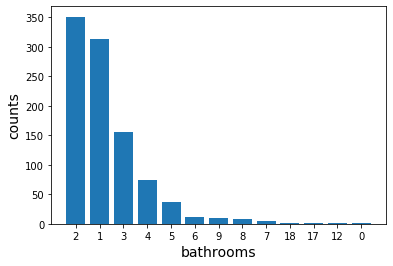

In [69]:
# Check the distribution of the number of bathrooms.

num_bathrooms = len(df.bathrooms.unique())
plt.bar(range(num_bathrooms), df.bathrooms.value_counts())
plt.xticks(range(num_bathrooms), df.bathrooms.value_counts().index)
plt.xlabel('bathrooms', fontsize=14)
plt.ylabel('counts', fontsize=14)

In [70]:
# Identify outlier and bad data for bathrooms.

b = df[(df['bathrooms'] == 0)].index.tolist()
b

[213]

In [71]:
# I checkd the website, this house has bathrooms, but it does not show in the website.

str(df.links[213])

'https://www.zillow.com/homedetails/170-Tremont-St-Cambridge-MA-02111/123958641_zpid/'

In [72]:
# Calculate the mean of bathrooms.

mean_bathrooms = int(df[df['bathrooms'] > 0].bathrooms.mean())
mean_bathrooms

2

In [73]:
# Using the mean value of bathrooms to replace 0.

df['bathrooms'].replace({0:2}, inplace=True)

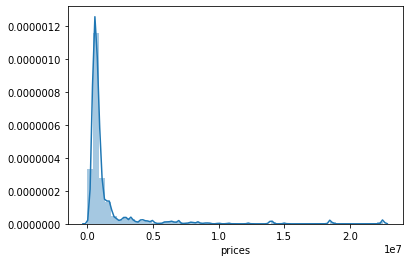

In [74]:
# Check the distribution of prices.

sns.distplot(df['prices'])
plt.show()

Text(0, 0.5, 'counts')

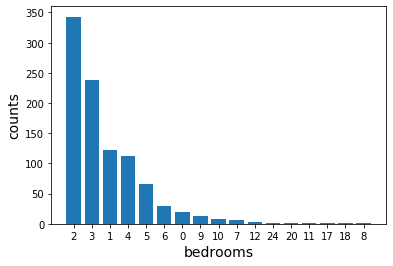

In [75]:
# Check of distribution of the number of bedrooms.

num_bedrooms = len(df.bedrooms.unique())
plt.bar(range(num_bedrooms), df.bedrooms.value_counts())
plt.xticks(range(num_bedrooms), df.bedrooms.value_counts().index)
plt.xlabel('bedrooms', fontsize=14)
plt.ylabel('counts', fontsize=14)

In [76]:
# Identify outlier and bad data for bedrooms.

a = df[(df['bedrooms'] == 0)].index.tolist()
a

[153,
 161,
 191,
 213,
 296,
 347,
 357,
 401,
 494,
 502,
 506,
 521,
 554,
 555,
 577,
 609,
 675,
 698,
 745]

In [77]:
# I checkd the website, they do not have bedrooms information.

str(df.links[153])

'https://www.zillow.com/homedetails/257-Marlborough-St-APT-2-Boston-MA-02116/59170249_zpid/'

In [78]:
# Calculate the mean of bedrooms.

mean_bedrooms = int(df[df['bedrooms'] > 0].bedrooms.mean())
mean_bedrooms

3

In [79]:
# Using the mean value of bedrooms to replace 0.

df['bedrooms'].replace({0:3}, inplace=True)

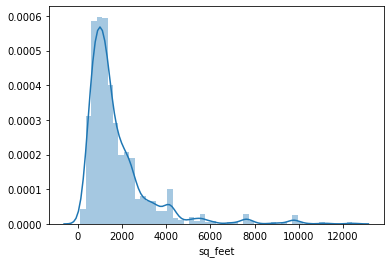

In [80]:
# Check the distribution of sq_feet.

sns.distplot(df['sq_feet'])
plt.show()

In [81]:
# Check the outlier and bad value for latitude and longitude. You can see no outlier and bad value, all these address are 
# in Boston.

latitude = 42.3601
longitude = -71.0589
house_map = folium.Map(location=[latitude, longitude], zoom_start=12)
addresses = folium.map.FeatureGroup()
for lat, lng in zip(df.lat, df.long):
    addresses.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7,
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4))

house_map.add_child(addresses)

In [82]:
# Check any duplicate.

df.duplicated().sum()

195

In [83]:
df.drop_duplicates()

,index,prices,address,links,bedrooms,bathrooms,sq_feet,zestimate,best_deal,long,lat
0,0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213
1,1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002
2,2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791
3,3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677
4,4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114
...,...,...,...,...,...,...,...,...,...,...,...
767,35,3999999.0,80-84 Shepton St Dorchester Center MA 02124,https://www.zillow.com/homedetails/80-84-Shept...,18,9,10170,637181.0,3362818.0,-71.059708,42.290382
768,36,575000.0,29 Ward St #102 Boston MA,https://www.zillow.com/homedetails/29-Ward-St-...,1,1,723,440623.0,134377.0,-71.054856,42.329492
769,37,899000.0,433 Columbus Ave APT 3 Boston MA 02116,https://www.zillow.com/homedetails/433-Columbu...,2,1,760,837857.0,61143.0,-71.077909,42.344051
770,38,429000.0,12 Kilsyth Ter APT 44 Boston MA 02135,https://www.zillow.com/homedetails/12-Kilsyth-...,1,1,692,770727.0,-341727.0,-71.147306,42.338973


In [3]:
# import the previously scrapped dataset for the houses in Boston

boston_data = pd.read_csv('../Web-Scraping-Zillow/boston.csv', index_col=0)
boston_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791
3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677
4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114


In [4]:
boston_data.dropna(subset=['lat','long'], inplace=True)

In [5]:
# choose the longitudes and latitudes in the dataset

longtitudes = boston_data.long.values
latitudes = boston_data.lat.values

In [14]:
# The purpose of the API is to pull the nearby venues for a specific house
# Let's take a look at an example

lat = latitudes[0]
lng = longtitudes[0]
radius = 8000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [15]:
# Let's take a look at the json data results

for result in results:
    print(result)

meta
response


In [8]:
# Let's take a look at the meta data

results['meta']

{'code': 200, 'requestId': '5f1e2d261b8cb27516ab64cc'}

In [9]:
# Let's take a look at the response data

for response in results['response']:
    print(response)

suggestedFilters
headerLocation
headerFullLocation
headerLocationGranularity
totalResults
suggestedBounds
groups


In [10]:
# I will focus on vanues in the 'groups' category, here's a glance at it.

results['response']['groups'][0]['items'][0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4a8e279ff964a5201f1220e3',
  'name': 'The Rose Kennedy Greenway',
  'location': {'address': 'Atlantic Ave.',
   'crossStreet': 'btwn Causeway & Kneeland',
   'lat': 42.358227345384506,
   'lng': -71.0520546770175,
   'labeledLatLngs': [{'label': 'display',
     'lat': 42.358227345384506,
     'lng': -71.0520546770175}],
   'distance': 148,
   'postalCode': '02110',
   'cc': 'US',
   'city': 'Boston',
   'state': 'MA',
   'country': 'United States',
   'formattedAddress': ['Atlantic Ave. (btwn Causeway & Kneeland)',
    'Boston, MA 02110',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d163941735',
    'name': 'Park',
    'pluralName': 'Parks',
    'shortName': 'Park',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {

What I want to get from the previous output is what kind of venue it is, for example, resteraunt, museum, park or something else. And I want to know how many this kind of places are there in a radius of 8000 m from the location of a specific house. In this sense, more information could be used to potentially fit the needs of a customer. To do so, I will append every venue's category name into list, and then use 'Counter' to see how many nearby venues are there.

In [11]:
# Let's take a look at the first house again, and see how many nearby venues are there

from collections import Counter
venue_list = []
for v in results["response"]['groups'][0]['items']:
    venue_list.append( v['venue']['categories'][0]['name'])
venue_count = sorted(Counter(venue_list).items(), key=lambda x: x[1], reverse=True)
for key, value in venue_count:
    print(f'{key} : {value}')

Park : 8
Bakery : 7
Seafood Restaurant : 5
Italian Restaurant : 5
Hotel : 4
Historic Site : 3
Restaurant : 3
Pizza Place : 3
Ice Cream Shop : 3
Gastropub : 3
Trail : 2
Sandwich Place : 2
Salad Place : 2
Mexican Restaurant : 2
Brewery : 2
Café : 2
Gym : 2
Pet Store : 2
French Restaurant : 2
Greek Restaurant : 2
Beer Garden : 1
Donut Shop : 1
Aquarium : 1
Vegetarian / Vegan Restaurant : 1
Library : 1
Museum : 1
Market : 1
Neighborhood : 1
Opera House : 1
Convenience Store : 1
Taco Place : 1
Gym / Fitness Center : 1
Garden : 1
Hockey Arena : 1
Grocery Store : 1
Outdoor Sculpture : 1
Yoga Studio : 1
Gourmet Shop : 1
Coffee Shop : 1
River : 1
Music Venue : 1
Science Museum : 1
Wine Shop : 1
Cupcake Shop : 1
Breakfast Spot : 1
Wine Bar : 1
Dessert Shop : 1
Spa : 1
Plaza : 1
American Restaurant : 1
Australian Restaurant : 1
Dive Bar : 1
Athletics & Sports : 1
Gift Shop : 1
Clothing Store : 1
Monument / Landmark : 1


We can see the example house has a few parks nearby, and a lot of restaurants nearby as well, hence could fit customers who are looking for these attributes from a house.

In [17]:
# Let's put it all together

import requests

# a radius of 8000 meters is used here, which is close to 5 miles
def getNearbyVenues(latitudes, longitudes, radius=8000):
    venues_lists = []
    for lat,lng in zip(latitudes, longtitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            v_list = [v['venue']['categories'][0]['name'] for v in results]
        except Exception as e:
            v_list = []
            pass
    
        venues_lists.append(v_list)
    return(venues_lists)

I want to mention that the free Sandbox Tier Accounts can make 950 Regular API Calls and 50 Premium API Calls per day, so be sure you have the sufficeint calls to pull the venue data  

In [18]:
# put it all together and 

longtitudes = boston_data.long.values
latitudes = boston_data.lat.values

boston_data['nearby_venues'] = getNearbyVenues(latitudes, longtitudes)

In [19]:
boston_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,nearby_venues
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,"[Park, Beer Garden, Donut Shop, Seafood Restau..."
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,"[Bar, Fruit & Vegetable Store, New American Re..."
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,"[Ice Cream Shop, Latin American Restaurant, Gr..."
3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677,"[Bakery, Ice Cream Shop, Park, Garden, Park, O..."
4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114,"[Latin American Restaurant, Fast Food Restaura..."


In [20]:
# save the data

boston_data.to_csv('boston_with_venues.csv')

In [205]:
boston_data = pd.read_csv('D:/Downloads/boston_with_venues.csv', index_col=0, header=0)

In [206]:
boston_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,nearby_venues
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,"['Park', 'Beer Garden', 'Donut Shop', 'Seafood..."
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,"['Bar', 'Fruit & Vegetable Store', 'New Americ..."
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,"['Ice Cream Shop', 'Latin American Restaurant'..."
3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677,"['Bakery', 'Ice Cream Shop', 'Park', 'Garden',..."
4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114,"['Latin American Restaurant', 'Fast Food Resta..."


In [207]:
def str2list(s):
    s = s.replace('[', '')
    s = s.replace(']', '')
    s = s.replace('\'','')
    return [i.strip() for i in s.split(',')] 

In [208]:
boston_data.nearby_venues = boston_data.nearby_venues.apply(lambda x: str2list(x))
boston_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,nearby_venues
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,"[Park, Beer Garden, Donut Shop, Seafood Restau..."
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,"[Bar, Fruit & Vegetable Store, New American Re..."
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,"[Ice Cream Shop, Latin American Restaurant, Gr..."
3,18500000.0,17 Louisburg Sq Boston MA 02108,https://www.zillow.com/homedetails/17-Louisbur...,5,5,7610,16857621.0,1642379.0,-71.068429,42.358677,"[Bakery, Ice Cream Shop, Park, Garden, Park, O..."
4,489000.0,102 Rockland St Dedham MA 02026,https://www.zillow.com/homedetails/102-Rocklan...,3,2,1408,500370.0,-11370.0,-71.156483,42.256114,"[Latin American Restaurant, Fast Food Restaura..."


In [209]:
venue_values = boston_data.nearby_venues.values.flatten()

In [210]:
# pull all of the venues into a single list

total_v = []
for v in venue_values:
    total_v = total_v + v

# convert it to a set to see the unique values
unique_venues  = set(total_v)

# print the number of unique venues
print(f'There are {len(unique_venues)} unique venues.')

There are 179 unique venues.


In [212]:
# Count the number of unique venues nearby for each house

from collections import Counter
for venue in unique_venues:
    # rename the column name by substitue ' ' with '_'
    col = '_'.join(venue.split())
    boston_data[col] = boston_data.nearby_venues.apply(lambda x:Counter(x)[venue])

In [213]:
boston_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,nearby_venues,Shoe_Store,Farm,Building,Salad_Place,Plaza,Sports_Bar,Fried_Chicken_Joint,Jazz_Club,River,Asian_Restaurant,Creperie,Café,"""Womens_Store""",Farmers_Market,Gas_Station,Yoga_Studio,Deli_/_Bodega,Trail,Fast_Food_Restaurant,Beer_Garden,Dog_Run,Opera_House,Salon_/_Barbershop,Eastern_European_Restaurant,Italian_Restaurant,Gourmet_Shop,"""Mens_Store""",Australian_Restaurant,Sandwich_Place,Music_Venue,Chinese_Restaurant,Gift_Shop,Bagel_Shop,Library,Smoothie_Shop,American_Restaurant,Ethiopian_Restaurant,Grocery_Store,Optical_Shop,Department_Store,Record_Shop,Pub,Clothing_Store,Lighthouse,Bubble_Tea_Shop,Latin_American_Restaurant,Beach,Pastry_Shop,Cuban_Restaurant,Mini_Golf,Rock_Club,Burger_Joint,Japanese_Restaurant,Burrito_Place,Comfort_Food_Restaurant,Theater,Mediterranean_Restaurant,Fruit_&_Vegetable_Store,Arepa_Restaurant,Boat_or_Ferry,Seafood_Restaurant,Boxing_Gym,Arts_&_Crafts_Store,Belgian_Restaurant,Cycle_Studio,Church,Zoo,Ski_Area,Fish_Market,National_Park,Electronics_Store,Science_Museum,Steakhouse,Mexican_Restaurant,Furniture_/_Home_Store,Art_Museum,Brewery,Vietnamese_Restaurant,Candy_Store,Indian_Restaurant,Swim_School,Cupcake_Shop,Historic_Site,Hotel,Hockey_Arena,Bistro,Peruvian_Restaurant,Wine_Shop,French_Restaurant,New_American_Restaurant,Gym,Lake,BBQ_Joint,Indie_Movie_Theater,Thai_Restaurant,Tapas_Restaurant,Pharmacy,Cosmetics_Shop,Monument_/_Landmark,Supermarket,Dive_Bar,Food_Court,Movie_Theater,Pizza_Place,Restaurant,Noodle_House,Caribbean_Restaurant,Park,Nail_Salon,Bar,Food_Truck,Bakery,Soccer_Field,Resort,Hotel_Bar,Taco_Place,Gastropub,Coffee_Shop,Diner,Miscellaneous_Shop,Neighborhood,Intersection,Baseball_Stadium,Dessert_Shop,"""Doctors_Office""",Pet_Store,Discount_Store,Accessories_Store,Big_Box_Store,Ice_Cream_Shop,History_Museum,Golf_Driving_Range,Spa,Cocktail_Bar,Meze_Restaurant,Aquarium,Juice_Bar,Organic_Grocery,Shopping_Mall,Middle_Eastern_Restaurant,Ramen_Restaurant,Skating_Rink,Convenience_Store,Health_&_Beauty_Service,Concert_Hall,Garden,Gym_/_Fitness_Center,Beer_Store,Track,Outdoor_Sculpture,Lounge,Warehouse_Store,Pool,Vegetarian_/_Vegan_Restaurant,Hot_Dog_Joint,General_Entertainment,Sushi_Restaurant,Video_Game_Store,Jewelry_Store,Greek_Restaurant,Liquor_Store,Climbing_Gym,Multiplex,Market,Athletics_&_Sports,Breakfast_Spot,Scenic_Lookout,Museum,Golf_Course,Southern_/_Soul_Food_Restaurant,Sporting_Goods_Shop,Thrift_/_Vintage_Store,Bookstore,Garden_Center,Donut_Shop,Bike_Shop,Jewish_Restaurant,Cheese_Shop,Wine_Bar
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,"[Park, Beer Garden, Donut Shop, Seafood Restau...",0,0,0,2,1,0,0,0,1,0,0,2,0,0,0,1,0,2,0,1,0,1,0,0,5,1,0,1,2,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0,0,1,3,4,1,0,0,1,2,0,2,0,0,0,0,0,0,0,1,0,1,0,0,3,3,0,0,8,0,0,0,7,0,0,0,1,3,1,0,0,1,0,0,1,0,2,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,"[Bar, Fruit & Vegetable Store, New American Re...",0,1,0,2,0,0,0,1,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,6,1,0,0,2,0,1,1,0,1,0,4,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,5,1,2,3,0,0,0,0,0,0,2,0,0,0,2,3,1,1,0,1,0,0,1,0,0,0,0,1,0,0,4,0,0,0,3,0,3,0,6,0,0,0,0,2,2,0,0,0,0,1,0,1,2,0,1,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,1
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,"[Ice Cream Shop, Latin American Restaurant, Gr...",0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,4,1,0,0,0,0,0,5,0,0,0,0,0,0,1,1,0,0,5,0,3,0,2,1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,2,2,0,1,0

In [214]:
boston_data.describe()

,prices,beds,sq_feet,zestimate,best_deal,long,lat,Shoe_Store,Farm,Building,Salad_Place,Plaza,Sports_Bar,Fried_Chicken_Joint,Jazz_Club,River,Asian_Restaurant,Creperie,Café,"""Womens_Store""",Farmers_Market,Gas_Station,Yoga_Studio,Deli_/_Bodega,Trail,Fast_Food_Restaurant,Beer_Garden,Dog_Run,Opera_House,Salon_/_Barbershop,Eastern_European_Restaurant,Italian_Restaurant,Gourmet_Shop,"""Mens_Store""",Australian_Restaurant,Sandwich_Place,Music_Venue,Chinese_Restaurant,Gift_Shop,Bagel_Shop,Library,Smoothie_Shop,American_Restaurant,Ethiopian_Restaurant,Grocery_Store,Optical_Shop,Department_Store,Record_Shop,Pub,Clothing_Store,Lighthouse,Bubble_Tea_Shop,Latin_American_Restaurant,Beach,Pastry_Shop,Cuban_Restaurant,Mini_Golf,Rock_Club,Burger_Joint,Japanese_Restaurant,Burrito_Place,Comfort_Food_Restaurant,Theater,Mediterranean_Restaurant,Fruit_&_Vegetable_Store,Arepa_Restaurant,Boat_or_Ferry,Seafood_Restaurant,Boxing_Gym,Arts_&_Crafts_Store,Belgian_Restaurant,Cycle_Studio,Church,Zoo,Ski_Area,Fish_Market,National_Park,Electronics_Store,Science_Museum,Steakhouse,Mexican_Restaurant,Furniture_/_Home_Store,Art_Museum,Brewery,Vietnamese_Restaurant,Candy_Store,Indian_Restaurant,Swim_School,Cupcake_Shop,Historic_Site,Hotel,Hockey_Arena,Bistro,Peruvian_Restaurant,Wine_Shop,French_Restaurant,New_American_Restaurant,Gym,Lake,BBQ_Joint,Indie_Movie_Theater,Thai_Restaurant,Tapas_Restaurant,Pharmacy,Cosmetics_Shop,Monument_/_Landmark,Supermarket,Dive_Bar,Food_Court,Movie_Theater,Pizza_Place,Restaurant,Noodle_House,Caribbean_Restaurant,Park,Nail_Salon,Bar,Food_Truck,Bakery,Soccer_Field,Resort,Hotel_Bar,Taco_Place,Gastropub,Coffee_Shop,Diner,Miscellaneous_Shop,Neighborhood,Intersection,Baseball_Stadium,Dessert_Shop,"""Doctors_Office""",Pet_Store,Discount_Store,Accessories_Store,Big_Box_Store,Ice_Cream_Shop,History_Museum,Golf_Driving_Range,Spa,Cocktail_Bar,Meze_Restaurant,Aquarium,Juice_Bar,Organic_Grocery,Shopping_Mall,Middle_Eastern_Restaurant,Ramen_Restaurant,Skating_Rink,Convenience_Store,Health_&_Beauty_Service,Concert_Hall,Garden,Gym_/_Fitness_Center,Beer_Store,Track,Outdoor_Sculpture,Lounge,Warehouse_Store,Pool,Vegetarian_/_Vegan_Restaurant,Hot_Dog_Joint,General_Entertainment,Sushi_Restaurant,Video_Game_Store,Jewelry_Store,Greek_Restaurant,Liquor_Store,Climbing_Gym,Multiplex,Market,Athletics_&_Sports,Breakfast_Spot,Scenic_Lookout,Museum,Golf_Course,Southern_/_Soul_Food_Restaurant,Sporting_Goods_Shop,Thrift_/_Vintage_Store,Bookstore,Garden_Center,Donut_Shop,Bike_Shop,Jewish_Restaurant,Cheese_Shop,Wine_Bar
count,9.670000e+02,967.000000,967.000000,9.670000e+02,9.670000e+02,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.00000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.00000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,

In [215]:
# reset index

boston_data.reset_index(inplace=True)

In [218]:
# drop duplicated data

drop_index = boston_data[boston_data.address.duplicated()].index
clean_data = boston_data.drop(index=drop_index)
clean_data.drop(columns=['index'], inplace=True)
clean_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,nearby_venues,Shoe_Store,Farm,Building,Salad_Place,Plaza,Sports_Bar,Fried_Chicken_Joint,Jazz_Club,River,Asian_Restaurant,Creperie,Café,"""Womens_Store""",Farmers_Market,Gas_Station,Yoga_Studio,Deli_/_Bodega,Trail,Fast_Food_Restaurant,Beer_Garden,Dog_Run,Opera_House,Salon_/_Barbershop,Eastern_European_Restaurant,Italian_Restaurant,Gourmet_Shop,"""Mens_Store""",Australian_Restaurant,Sandwich_Place,Music_Venue,Chinese_Restaurant,Gift_Shop,Bagel_Shop,Library,Smoothie_Shop,American_Restaurant,Ethiopian_Restaurant,Grocery_Store,Optical_Shop,Department_Store,Record_Shop,Pub,Clothing_Store,Lighthouse,Bubble_Tea_Shop,Latin_American_Restaurant,Beach,Pastry_Shop,Cuban_Restaurant,Mini_Golf,Rock_Club,Burger_Joint,Japanese_Restaurant,Burrito_Place,Comfort_Food_Restaurant,Theater,Mediterranean_Restaurant,Fruit_&_Vegetable_Store,Arepa_Restaurant,Boat_or_Ferry,Seafood_Restaurant,Boxing_Gym,Arts_&_Crafts_Store,Belgian_Restaurant,Cycle_Studio,Church,Zoo,Ski_Area,Fish_Market,National_Park,Electronics_Store,Science_Museum,Steakhouse,Mexican_Restaurant,Furniture_/_Home_Store,Art_Museum,Brewery,Vietnamese_Restaurant,Candy_Store,Indian_Restaurant,Swim_School,Cupcake_Shop,Historic_Site,Hotel,Hockey_Arena,Bistro,Peruvian_Restaurant,Wine_Shop,French_Restaurant,New_American_Restaurant,Gym,Lake,BBQ_Joint,Indie_Movie_Theater,Thai_Restaurant,Tapas_Restaurant,Pharmacy,Cosmetics_Shop,Monument_/_Landmark,Supermarket,Dive_Bar,Food_Court,Movie_Theater,Pizza_Place,Restaurant,Noodle_House,Caribbean_Restaurant,Park,Nail_Salon,Bar,Food_Truck,Bakery,Soccer_Field,Resort,Hotel_Bar,Taco_Place,Gastropub,Coffee_Shop,Diner,Miscellaneous_Shop,Neighborhood,Intersection,Baseball_Stadium,Dessert_Shop,"""Doctors_Office""",Pet_Store,Discount_Store,Accessories_Store,Big_Box_Store,Ice_Cream_Shop,History_Museum,Golf_Driving_Range,Spa,Cocktail_Bar,Meze_Restaurant,Aquarium,Juice_Bar,Organic_Grocery,Shopping_Mall,Middle_Eastern_Restaurant,Ramen_Restaurant,Skating_Rink,Convenience_Store,Health_&_Beauty_Service,Concert_Hall,Garden,Gym_/_Fitness_Center,Beer_Store,Track,Outdoor_Sculpture,Lounge,Warehouse_Store,Pool,Vegetarian_/_Vegan_Restaurant,Hot_Dog_Joint,General_Entertainment,Sushi_Restaurant,Video_Game_Store,Jewelry_Store,Greek_Restaurant,Liquor_Store,Climbing_Gym,Multiplex,Market,Athletics_&_Sports,Breakfast_Spot,Scenic_Lookout,Museum,Golf_Course,Southern_/_Soul_Food_Restaurant,Sporting_Goods_Shop,Thrift_/_Vintage_Store,Bookstore,Garden_Center,Donut_Shop,Bike_Shop,Jewish_Restaurant,Cheese_Shop,Wine_Bar
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,"[Park, Beer Garden, Donut Shop, Seafood Restau...",0,0,0,2,1,0,0,0,1,0,0,2,0,0,0,1,0,2,0,1,0,1,0,0,5,1,0,1,2,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0,0,1,3,4,1,0,0,1,2,0,2,0,0,0,0,0,0,0,1,0,1,0,0,3,3,0,0,8,0,0,0,7,0,0,0,1,3,1,0,0,1,0,0,1,0,2,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,"[Bar, Fruit & Vegetable Store, New American Re...",0,1,0,2,0,0,0,1,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,6,1,0,0,2,0,1,1,0,1,0,4,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,5,1,2,3,0,0,0,0,0,0,2,0,0,0,2,3,1,1,0,1,0,0,1,0,0,0,0,1,0,0,4,0,0,0,3,0,3,0,6,0,0,0,0,2,2,0,0,0,0,1,0,1,2,0,1,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,1
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,"[Ice Cream Shop, Latin American Restaurant, Gr...",0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,4,1,0,0,0,0,0,5,0,0,0,0,0,0,1,1,0,0,5,0,3,0,2,1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,2,2,0,1,0

In [219]:
data_2= clean_data[['lat', 'long']]

In [220]:
data_3= crimedf[['Lat', 'Long']]

In [221]:
from geopy.distance import geodesic

In [222]:
# calculate the number of crimes happened closer than 2 km to a house

num_crime = []
for house_loc in data_2.values:
    temp = []
    for crime_lat, crime_long in data_3.values:
        temp.append(geodesic((house_loc[0], house_loc[1]), (crime_lat, crime_long)).km)
    num_crime.append(sum(np.array(temp)<2))

In [223]:
clean_data['num_crimes'] = num_crime
clean_data.head()

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,nearby_venues,Shoe_Store,Farm,Building,Salad_Place,Plaza,Sports_Bar,Fried_Chicken_Joint,Jazz_Club,River,Asian_Restaurant,Creperie,Café,"""Womens_Store""",Farmers_Market,Gas_Station,Yoga_Studio,Deli_/_Bodega,Trail,Fast_Food_Restaurant,Beer_Garden,Dog_Run,Opera_House,Salon_/_Barbershop,Eastern_European_Restaurant,Italian_Restaurant,Gourmet_Shop,"""Mens_Store""",Australian_Restaurant,Sandwich_Place,Music_Venue,Chinese_Restaurant,Gift_Shop,Bagel_Shop,Library,Smoothie_Shop,American_Restaurant,Ethiopian_Restaurant,Grocery_Store,Optical_Shop,Department_Store,Record_Shop,Pub,Clothing_Store,Lighthouse,Bubble_Tea_Shop,Latin_American_Restaurant,Beach,Pastry_Shop,Cuban_Restaurant,Mini_Golf,Rock_Club,Burger_Joint,Japanese_Restaurant,Burrito_Place,Comfort_Food_Restaurant,Theater,Mediterranean_Restaurant,Fruit_&_Vegetable_Store,Arepa_Restaurant,Boat_or_Ferry,Seafood_Restaurant,Boxing_Gym,Arts_&_Crafts_Store,Belgian_Restaurant,Cycle_Studio,Church,Zoo,Ski_Area,Fish_Market,National_Park,Electronics_Store,Science_Museum,Steakhouse,Mexican_Restaurant,Furniture_/_Home_Store,Art_Museum,Brewery,Vietnamese_Restaurant,Candy_Store,Indian_Restaurant,Swim_School,Cupcake_Shop,Historic_Site,Hotel,Hockey_Arena,Bistro,Peruvian_Restaurant,Wine_Shop,French_Restaurant,New_American_Restaurant,Gym,Lake,BBQ_Joint,Indie_Movie_Theater,Thai_Restaurant,Tapas_Restaurant,Pharmacy,Cosmetics_Shop,Monument_/_Landmark,Supermarket,Dive_Bar,Food_Court,Movie_Theater,Pizza_Place,Restaurant,Noodle_House,Caribbean_Restaurant,Park,Nail_Salon,Bar,Food_Truck,Bakery,Soccer_Field,Resort,Hotel_Bar,Taco_Place,Gastropub,Coffee_Shop,Diner,Miscellaneous_Shop,Neighborhood,Intersection,Baseball_Stadium,Dessert_Shop,"""Doctors_Office""",Pet_Store,Discount_Store,Accessories_Store,Big_Box_Store,Ice_Cream_Shop,History_Museum,Golf_Driving_Range,Spa,Cocktail_Bar,Meze_Restaurant,Aquarium,Juice_Bar,Organic_Grocery,Shopping_Mall,Middle_Eastern_Restaurant,Ramen_Restaurant,Skating_Rink,Convenience_Store,Health_&_Beauty_Service,Concert_Hall,Garden,Gym_/_Fitness_Center,Beer_Store,Track,Outdoor_Sculpture,Lounge,Warehouse_Store,Pool,Vegetarian_/_Vegan_Restaurant,Hot_Dog_Joint,General_Entertainment,Sushi_Restaurant,Video_Game_Store,Jewelry_Store,Greek_Restaurant,Liquor_Store,Climbing_Gym,Multiplex,Market,Athletics_&_Sports,Breakfast_Spot,Scenic_Lookout,Museum,Golf_Course,Southern_/_Soul_Food_Restaurant,Sporting_Goods_Shop,Thrift_/_Vintage_Store,Bookstore,Garden_Center,Donut_Shop,Bike_Shop,Jewish_Restaurant,Cheese_Shop,Wine_Bar,num_crimes
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,"[Park, Beer Garden, Donut Shop, Seafood Restau...",0,0,0,2,1,0,0,0,1,0,0,2,0,0,0,1,0,2,0,1,0,1,0,0,5,1,0,1,2,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0,0,1,3,4,1,0,0,1,2,0,2,0,0,0,0,0,0,0,1,0,1,0,0,3,3,0,0,8,0,0,0,7,0,0,0,1,3,1,0,0,1,0,0,1,0,2,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,48
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,"[Bar, Fruit & Vegetable Store, New American Re...",0,1,0,2,0,0,0,1,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,6,1,0,0,2,0,1,1,0,1,0,4,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,5,1,2,3,0,0,0,0,0,0,2,0,0,0,2,3,1,1,0,1,0,0,1,0,0,0,0,1,0,0,4,0,0,0,3,0,3,0,6,0,0,0,0,2,2,0,0,0,0,1,0,1,2,0,1,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,1,409
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,"[Ice Cream Shop, Latin American Restaurant, Gr...",0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,4,1,0,0,0,0,0,5,0,0,0,0,0,0,1,1,0,0,5,0,3,0,2,1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,0,1,0,0,1,0

In [224]:
clean_data.to_csv('final_data.csv')

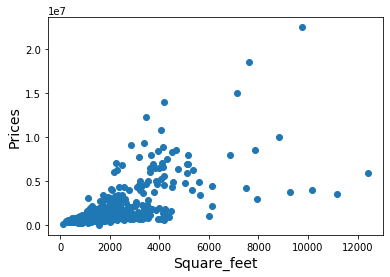

In [230]:
# The first visualization, the relationship between sq_feet and prices

plt.scatter(clean_data['sq_feet'], clean_data['prices'])
plt.xlabel('Square_feet', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.show()

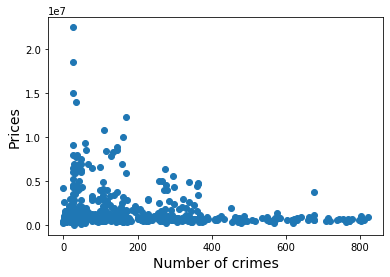

In [231]:
# The second visualization, the relationship between number of crimes happened closer than 2 km to a house and prices

plt.scatter(clean_data['num_crimes'], clean_data['prices'])
plt.xlabel('Number of crimes', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.show()

In [276]:
# select data and replace the improper string '--' with 0 
new_data = clean_data[['prices', 'beds', 'baths', 'num_crimes']]
new_data.baths = new_data.baths.apply(lambda x: x.replace('--', '0'))

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [277]:
new_data.baths = new_data.baths.astype('int')

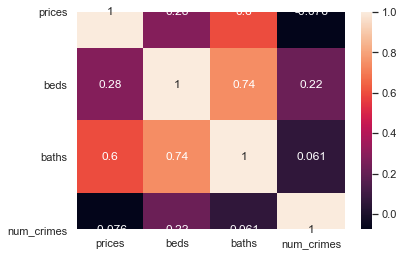

In [362]:
# The third visualization: the correlation of prices, beds, baths and num_crimes

sns.set()
sns.heatmap(new_data.corr(), annot=True)
plt.yticks(rotation=0)
plt.show()

In [289]:
clean_data.columns[11:-1]

Index(['Shoe_Store', 'Farm', 'Building', 'Salad_Place', 'Plaza', 'Sports_Bar', 'Fried_Chicken_Joint', 'Jazz_Club', 'River', 'Asian_Restaurant',
       ...
       'Southern_/_Soul_Food_Restaurant', 'Sporting_Goods_Shop', 'Thrift_/_Vintage_Store', 'Bookstore', 'Garden_Center', 'Donut_Shop', 'Bike_Shop', 'Jewish_Restaurant', 'Cheese_Shop', 'Wine_Bar'], dtype='object', length=179)

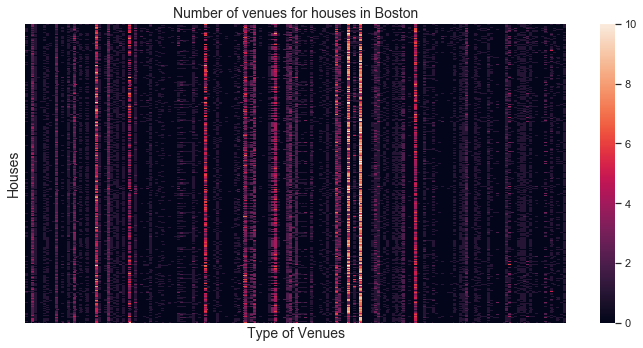

In [354]:
# The forth visualization: type of venues each house has 

places_data = clean_data[clean_data.columns[11:-1]]
plt.figure(figsize=(10,5))
sns.heatmap(places_data, vmin=0, vmax=10, annot=False)
plt.yticks([])
plt.xticks([])
plt.xlabel('Type of Venues', fontsize=14)
plt.ylabel('Houses', fontsize=14)
plt.title('Number of venues for houses in Boston', fontsize=14)
plt.tight_layout()
plt.show()

In [336]:
# The fifth visualization: the number of crimes based on the latitude and longitude.

latitude = 42.3601
longitude = -71.0589
house_map = folium.Map(location=[latitude, longitude], zoom_start=12)
addresses = folium.map.FeatureGroup()
for num_crime, lat, lng in zip(clean_data.num_crimes, clean_data.lat, clean_data.long):
    addresses.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=num_crime//100,
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4))

house_map.add_child(addresses)

In [342]:
# drop the column whose data is list

clean_data.drop(columns=['nearby_venues'], inplace=True)

In [349]:
# create a connection to SQL database, and create a new table on SQL DB.

conn = sqlite3.connect('finalprojectdb.db')
clean_data.to_sql('clean_data', conn, if_exists='replace', index=False)
pd.read_sql('SELECT * From clean_data', conn)

,prices,address,links,beds,baths,sq_feet,zestimate,best_deal,long,lat,Shoe_Store,Farm,Building,Salad_Place,Plaza,Sports_Bar,Fried_Chicken_Joint,Jazz_Club,River,Asian_Restaurant,Creperie,Café,"""Womens_Store""",Farmers_Market,Gas_Station,Yoga_Studio,Deli_/_Bodega,Trail,Fast_Food_Restaurant,Beer_Garden,Dog_Run,Opera_House,Salon_/_Barbershop,Eastern_European_Restaurant,Italian_Restaurant,Gourmet_Shop,"""Mens_Store""",Australian_Restaurant,Sandwich_Place,Music_Venue,Chinese_Restaurant,Gift_Shop,Bagel_Shop,Library,Smoothie_Shop,American_Restaurant,Ethiopian_Restaurant,Grocery_Store,Optical_Shop,Department_Store,Record_Shop,Pub,Clothing_Store,Lighthouse,Bubble_Tea_Shop,Latin_American_Restaurant,Beach,Pastry_Shop,Cuban_Restaurant,Mini_Golf,Rock_Club,Burger_Joint,Japanese_Restaurant,Burrito_Place,Comfort_Food_Restaurant,Theater,Mediterranean_Restaurant,Fruit_&_Vegetable_Store,Arepa_Restaurant,Boat_or_Ferry,Seafood_Restaurant,Boxing_Gym,Arts_&_Crafts_Store,Belgian_Restaurant,Cycle_Studio,Church,Zoo,Ski_Area,Fish_Market,National_Park,Electronics_Store,Science_Museum,Steakhouse,Mexican_Restaurant,Furniture_/_Home_Store,Art_Museum,Brewery,Vietnamese_Restaurant,Candy_Store,Indian_Restaurant,Swim_School,Cupcake_Shop,Historic_Site,Hotel,Hockey_Arena,Bistro,Peruvian_Restaurant,Wine_Shop,French_Restaurant,New_American_Restaurant,Gym,Lake,BBQ_Joint,Indie_Movie_Theater,Thai_Restaurant,Tapas_Restaurant,Pharmacy,Cosmetics_Shop,Monument_/_Landmark,Supermarket,Dive_Bar,Food_Court,Movie_Theater,Pizza_Place,Restaurant,Noodle_House,Caribbean_Restaurant,Park,Nail_Salon,Bar,Food_Truck,Bakery,Soccer_Field,Resort,Hotel_Bar,Taco_Place,Gastropub,Coffee_Shop,Diner,Miscellaneous_Shop,Neighborhood,Intersection,Baseball_Stadium,Dessert_Shop,"""Doctors_Office""",Pet_Store,Discount_Store,Accessories_Store,Big_Box_Store,Ice_Cream_Shop,History_Museum,Golf_Driving_Range,Spa,Cocktail_Bar,Meze_Restaurant,Aquarium,Juice_Bar,Organic_Grocery,Shopping_Mall,Middle_Eastern_Restaurant,Ramen_Restaurant,Skating_Rink,Convenience_Store,Health_&_Beauty_Service,Concert_Hall,Garden,Gym_/_Fitness_Center,Beer_Store,Track,Outdoor_Sculpture,Lounge,Warehouse_Store,Pool,Vegetarian_/_Vegan_Restaurant,Hot_Dog_Joint,General_Entertainment,Sushi_Restaurant,Video_Game_Store,Jewelry_Store,Greek_Restaurant,Liquor_Store,Climbing_Gym,Multiplex,Market,Athletics_&_Sports,Breakfast_Spot,Scenic_Lookout,Museum,Golf_Course,Southern_/_Soul_Food_Restaurant,Sporting_Goods_Shop,Thrift_/_Vintage_Store,Bookstore,Garden_Center,Donut_Shop,Bike_Shop,Jewish_Restaurant,Cheese_Shop,Wine_Bar,num_crimes
0,299900.0,2011 Waukesha Rd Boston WI 02110,https://www.zillow.com/homedetails/2011-Waukes...,3,2,1226,295523.0,4377.0,-71.053236,42.357213,0,0,0,2,1,0,0,0,1,0,0,2,0,0,0,1,0,2,0,1,0,1,0,0,5,1,0,1,2,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,2,0,0,0,0,1,3,4,1,0,0,1,2,0,2,0,0,0,0,0,0,0,1,0,1,0,0,3,3,0,0,8,0,0,0,7,0,0,0,1,3,1,0,0,1,0,0,1,0,2,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,48
1,549900.0,75 Maxwell St Boston MA 02124,https://www.zillow.com/homedetails/75-Maxwell-...,4,3,1800,549903.0,-3.0,-71.079630,42.282002,0,1,0,2,0,0,0,1,0,0,0,2,0,1,0,1,0,1,0,0,0,0,0,0,6,1,0,0,2,0,1,1,0,1,0,4,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,5,1,2,3,0,0,0,0,0,0,2,0,0,0,2,3,1,1,0,1,0,0,1,0,0,0,0,1,0,0,4,0,0,0,3,0,3,0,6,0,0,0,0,2,2,0,0,0,0,1,0,1,2,0,1,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,1,409
2,785000.0,2 Maple Leaf Dr Boston MA 02136,https://www.zillow.com/homedetails/2-Maple-Lea...,4,4,2479,785006.0,-6.0,-71.140084,42.248791,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,4,1,0,0,0,0,0,5,0,0,0,0,0,0,1,1,0,0,5,0,3,0,2,1,0,0,0,0,1,0,0,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,2,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,3,1,0,0,0,0,1,1,0,1,0,0,0,2,1,0,0,4,1,1,1,2,0,0,0,0,0,5,1,0,0,0,0,0,0,1,1,0,1,6,0,0,1,0,0,0,0,0,2,0,0,1,0,1,0,0,2,0,0,0,0,1,1,0

## Summary

In summary, here in this project, I used three type of data, the first one is the Boston crime incident report dataset available at data.boston.gov, in which crime incidents with the location of the crime happened, time, and severity of the crime etc. are included in the dataset; the second one is the house price data I scraped from zillow.com, which has the information of the geographic location of the houses, the price, number of bathrooms, number of bedrooms, the size of the houses, etc., the third data is from the Foursquares API, where I used the house location to find the nearby venues, such as cinemas, restaurants, trails, parks, museums, etc.

The purpose of the project is to provide valuable information for potential house purchasers in the city of Boston, based on their potential budget, safety concerns, and the needs for the type of life, such as if one likes jogging or walking, a house has trails nearby would be a good choice, and if one is a big fan of movies, nearby cinema would be of interest. By search the nearby venues for each house using the Foursquares API. I counted the number of each venues nearby and complement the scraped Zillow house information with the number of all nearby venues. So basically, the Zillow house data and the Foursquares data are joined with the geographic data, namely, latitude and longitude of the house. Use a similar approach, I also calculated the distance of each crime incident reported in the Boston crime incident report and all of the houses, I then counted the number of incident reported for each house within a radius of 2 km nearby, and added this data to the house information dataset. In this sense, the crime incident data and the house information are also joined with respect to the geographic information. The number of crime incidents happened are visualized using the Folium package.

Eventually, I am able to have a data set having the price of the house, the size, number of bedrooms, number of bathrooms, the estimated price, geographic information of the house, the number of all of the nearby venues, and the number of crime incidents happened in a vicinity of 2 km. This dataset could be used to recommend houses purchasers by taking the customers’ need and calculate the similarity between the need and the house information available.
